In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/video1/video11.zip' -d '/content/drive/MyDrive/video1'

Archive:  /content/drive/MyDrive/video1/video11.zip
   creating: /content/drive/MyDrive/video1/video11/
   creating: /content/drive/MyDrive/video1/video11/fight/
  inflating: /content/drive/MyDrive/video1/video11/fight/fi001.mp4  
  inflating: /content/drive/MyDrive/video1/video11/fight/fi002.mp4  
  inflating: /content/drive/MyDrive/video1/video11/fight/fi003.mp4  
  inflating: /content/drive/MyDrive/video1/video11/fight/fi004.mp4  
  inflating: /content/drive/MyDrive/video1/video11/fight/fi005.mp4  
  inflating: /content/drive/MyDrive/video1/video11/fight/fi006.mp4  
  inflating: /content/drive/MyDrive/video1/video11/fight/fi007.mp4  
  inflating: /content/drive/MyDrive/video1/video11/fight/fi008.mp4  
  inflating: /content/drive/MyDrive/video1/video11/fight/fi009.mp4  
  inflating: /content/drive/MyDrive/video1/video11/fight/fi010.mp4  
  inflating: /content/drive/MyDrive/video1/video11/fight/fi011.mp4  
  inflating: /content/drive/MyDrive/video1/video11/fight/fi012.mp4  
  inflatin

In [ ]:
import os
import cv2
import math
#import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2506752/45929032 bytes (5.5%)5873664/45929032 bytes (12.8%)8871936/45929032 bytes (19.3%)12140544/45929032 bytes (26.4%)15384576/45929032 bytes (33.5%)18759680/45929032 bytes (40.8%)21848064/45929032 bytes (47.6%)25133056/45929032 bytes (54.7%)28295168/45929032 bytes (61.6%)31637504/45929032 bytes (68.9%)34824192/45929032 bytes (75.8%)38166528/45929032 bytes (83.1%)

In [ ]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)


In [ ]:
image_height, image_width = 64, 64

max_images_per_class = 8000

 

dataset_directory = "/content/drive/MyDrive/video1/video11"

classes_list = ["noFight", "fight"]
model_output_size = len(classes_list)


In [ ]:
def frames_extraction(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  while True:
    success, frame = video_reader.read()
    if not success:
      break
    resized_frame = cv2.resize(frame, (image_height, image_width))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list


In [ ]:
def create_dataset():
  temp_features = []
  features = []
  labels = []
  for class_index, class_name in enumerate(classes_list):
    print(f'Extracting Data of Class: {class_name}')
    files_list = os.listdir(os.path.join(dataset_directory, class_name))
    for file_name in files_list:
      video_file_path = os.path.join(dataset_directory, class_name, file_name)
      frames = frames_extraction(video_file_path)
      temp_features.extend(frames)
    features.extend(random.sample(temp_features, max_images_per_class))
    labels.extend([class_index] * max_images_per_class)
    temp_features.clear()
  features = np.asarray(features)
  labels = np.array(labels) 
  return features, labels


In [ ]:
features, labels = create_dataset()


Extracting Data of Class: noFight
Extracting Data of Class: fight


In [ ]:
one_hot_encoded_labels = to_categorical(labels)


In [ ]:

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [ ]:

def create_model():
  model = Sequential()
  model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
  model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(model_output_size, activation = 'softmax'))
  model.summary()
  return model
model = create_model()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
2560/2560 [==============================] - 64s 14ms/step - loss: 0.7051 - accuracy: 0.5679 - val_loss: 1.7753 - val_accuracy: 0.5008
Epoch 2/50
2560/2560 [==============================] - 32s 13ms/step - loss: 0.6790 - accuracy: 0.5975 - val_loss: 2.8926 - val_accuracy: 0.5047
Epoch 3/50
2560/2560 [==============================] - 26s 10ms/step - loss: 0.6467 - accuracy: 0.6342 - val_loss: 0.6573 - val_accuracy: 0.6313
Epoch 4/50
2560/2560 [==============================] - 25s 10ms/step - loss: 0.6153 - accuracy: 0.6649 - val_loss: 0.8360 - val_accuracy: 0.5129
Epoch 5/50
2560/2560 [==============================] - 26s 10ms/step - loss: 0.5934 - accuracy: 0.6797 - val_loss: 1.2455 - val_accuracy: 0.5039
Epoch 6/50
2560/2560 [==============================] - 26s 10ms/step - loss: 0.5675 - accuracy: 0.7035 - val_loss: 0.6723 - val_accuracy: 0.6285
Epoch 7/50
2560/2560 [==============================] - 27s 11ms/step - loss: 0.5379 - accuracy: 0.7241 - val_loss: 1.0219 -

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)


100/100 [==============================] - 1s 9ms/step - loss: 0.0579 - accuracy: 0.9825


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_pred = model.predict(features_test
                       )

In [ ]:
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(labels_test, axis = 1)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1604
           1       1.00      0.97      0.98      1596

    accuracy                           0.98      3200
   macro avg       0.98      0.98      0.98      3200
weighted avg       0.98      0.98      0.98      3200



In [19]:
model.save('CNN.h5')

In [20]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]
  epochs = range(len(metric_value_1))
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  plt.title(str(plot_name))
  plt.legend()


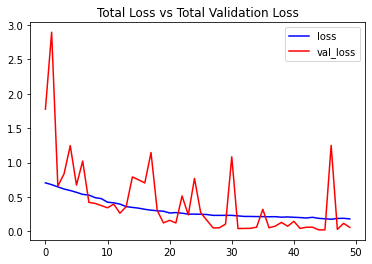

In [21]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

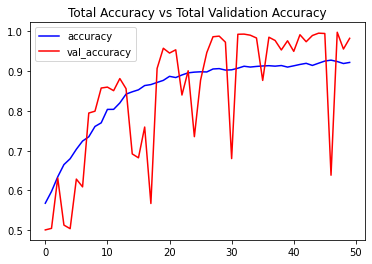

In [22]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [23]:
def make_average_predictions(video_file_path, predictions_frames_count):
  predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)
  video_reader = cv2.VideoCapture(video_file_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = video_frames_count // predictions_frames_count
  for frame_counter in range(predictions_frames_count):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    _ , frame = video_reader.read()
    resized_frame = cv2.resize(frame, (image_height, image_width))
    normalized_frame = resized_frame / 255
    predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]
    predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities
  predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
  predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]
  for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:
    predicted_class_name = classes_list[predicted_label]
    predicted_probability = predicted_labels_probabilities_averaged[predicted_label]
    print(f"Class Name: {predicted_class_name}   Averaged probability: {round(predicted_probability*100,2)} %")

  video_reader.release()


In [24]:
video_file1 ='/content/NV_1.mp4'

In [25]:
VideoFileClip(video_file1).ipython_display(width = 700)

100%|██████████| 73/73 [00:02<00:00, 24.56it/s]


In [26]:
make_average_predictions(video_file1,60)

Class Name: noFight   Averaged probability: 98.86 %
Class Name: fight   Averaged probability: 1.14 %


In [27]:
video_file2 ='/content/V_119.mp4'

In [28]:
VideoFileClip(video_file2).ipython_display(width=700)

100%|██████████| 154/154 [00:02<00:00, 61.85it/s]


In [29]:
make_average_predictions(video_file2,150)

Class Name: fight   Averaged probability: 94.63 %
Class Name: noFight   Averaged probability: 5.37 %
